# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Загрузим необходимые библиотеки

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Загрузим файл с данными, посмотрим информацию о датасете.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Посмотрим даннае о распределении данных по возрастам и построим график распределения возраста в выборке.

In [3]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


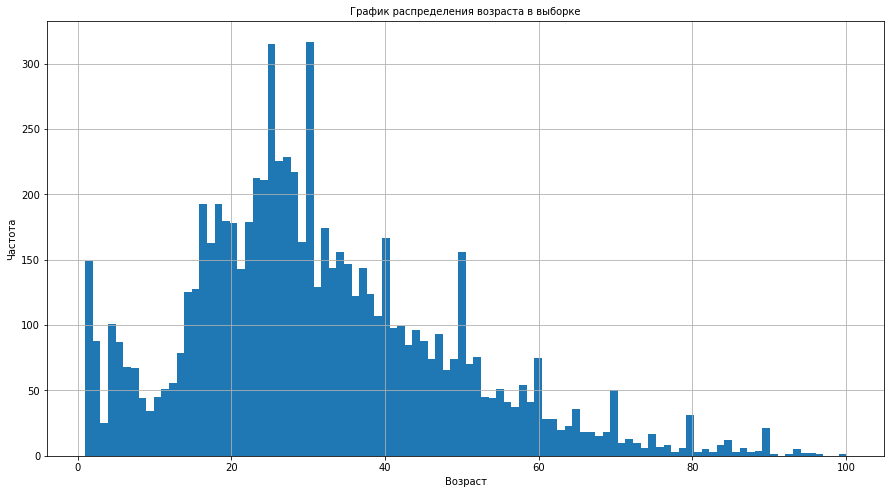

In [4]:
labels.hist(bins=100, figsize=(15,8))
plt.title('График распределения возраста в выборке', fontsize=10)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show();

### Загрузим данные c фотографиями

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow =datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


### Выведим на экран 15 фотографий

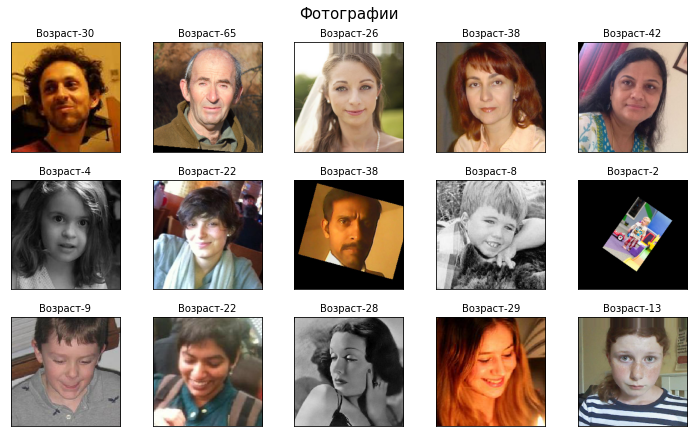

In [11]:
features, target = next(data_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    plt.suptitle('Фотографии', fontsize=15)
    fig.add_subplot(5, 5, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
1. Размер выборки составляет 7591 фотографий людей. Пропусков в данных нет.
2. Распределение возраста в выборке адекватное, но неравномерное, это может усложнить решение нашей задачи,т.к. фото людей определенных возрастных категорий может быть не достаточно для обучения модели.Большинство людей на фотографиях в возрасте от 20 до 41 года. Минимальный возраст в выборке 1 год, максимальный 100 лет, анамольных значений не наблюдается. Есть небольшой хвост справа, но он в рамках адекватных значений возраста. 
3. Среди фотографий есть цветные и чернробелые, сделанные под разным углом. Встречаются фотографии с предметами, которые закрывают лица. Для дальнейщего обучения модели, все фотографии были приведены к одному размеру.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Для решения поставленной задачи было принято использовать предобученную на ImageNet сверточную сеть c архитектурой ResNet50. Для адаптации данной сети к нашей задаче регресии, в которой мы определяем возраст человека по фотографии, убираем верхушку сети и конструируем заново. В качестве заключительных слоев используем:
- GlobalAveragePooling2D;
- Dense(1, activation='relu') - посносвязный слой с 1 нейронам (задача регрессии) и функцией активации ReLu.
В качестве функции потерь будем использовать MSE, отслежтвать будем мертрику качества МАЕ, которая по условяи задачи на тестовой выборке должна быть не больше 8.
Замораживать слои не будем, т.к. данных достаточно. Для аугментации данных используем вертикальный флип.

```python

# 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255., horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_data 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
 
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
        
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
         steps_per_epoch = len(train_data)  
    if validation_steps is None:
         validation_step = len(test_data)     
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```

# Train for 356 steps, validate for 119 steps
Epoch 1/12
2024-02-07 09:25:54.457482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-07 09:25:54.779347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 68s - loss: 204.6025 - mae: 10.4329 - val_loss: 595.3210 - val_mae: 19.2867
Epoch 2/12
356/356 - 55s - loss: 82.0401 - mae: 6.9433 - val_loss: 126.3894 - val_mae: 8.3208
Epoch 3/12
356/356 - 55s - loss: 59.0833 - mae: 5.8271 - val_loss: 77.6094 - val_mae: 6.5323
Epoch 4/12
356/356 - 55s - loss: 41.8493 - mae: 4.9904 - val_loss: 76.9356 - val_mae: 6.4874
Epoch 5/12
356/356 - 55s - loss: 32.2213 - mae: 4.3220 - val_loss: 74.1235 - val_mae: 6.5269
Epoch 6/12
356/356 - 56s - loss: 25.0199 - mae: 3.8333 - val_loss: 69.7377 - val_mae: 6.1533
Epoch 7/12
356/356 - 56s - loss: 19.0766 - mae: 3.3452 - val_loss: 69.8689 - val_mae: 6.2352
Epoch 8/12
356/356 - 56s - loss: 16.0877 - mae: 3.0828 - val_loss: 70.0016 - val_mae: 6.2926
Epoch 9/12
356/356 - 55s - loss: 14.5289 - mae: 2.9206 - val_loss: 75.4271 - val_mae: 6.3712
Epoch 10/12
356/356 - 55s - loss: 13.7579 - mae: 2.8123 - val_loss: 68.4894 - val_mae: 6.2596
Epoch 11/12
356/356 - 55s - loss: 13.7746 - mae: 2.7872 - val_loss: 63.9383 - val_mae: 5.9820
Epoch 12/12
356/356 - 56s - loss: 12.5181 - mae: 2.6998 - val_loss: 62.0368 - val_mae: 5.8943
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 62.0368 - mae: 5.8943
Test MAE: 5.8943

# 

```

## Анализ обученной модели

**Итоговый вывод:**

Перед нами была поставлена задача разработать и обучить модель, которая определяла бы возраст покупателя по его снимкам. 
Данную модель планировалось использовать заказчиком для решения следующих задач:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Загрузив данные и проведя иссследовательский анализ данных было решено использовать предобученную на ImageNet сверточную сеть c архитектурой ResNet50. Для адаптации данной сети к нашей задаче регресии, в которой мы определяем возраст человека по фотографии, убирали верхушку сети и сконструировали ее заново. 
В качестве заключительных слоев использовали:

 - GlobalAveragePooling2D;
 - Dense(1, activation='relu') - посносвязный слой с 1 нейронам (задача регрессии) и функцией активации ReLu. 
 
В качестве функции потерь использовали MSE, отслежтвали мертрику качества МАЕ, которая по условяи задачи на тестовой выборке должна быть не больше 8. Замораживать слои не стали, т.к. данных достаточно. Для аугментации данных использовали горизонтальный флип. В качество оптимизатора использовали алгоритм Adam с шагом обучения - 0.0001.

В результате проведения обучения модели на 12 эпохах были полученны следующие значения МАЕ 2.6998 и 5.8943 на обучающей и тестовой выборке соответственно. Такие результаты удовлетворяют поставленной задаче - MAE меньше 8 на тестовой выборке.  Таким образом была построена и обучена модель, которая удовлетворят требованиям качества. 

С учетом полученного значния МАЕ на тестовой выборке данную модель можно рекомендовать для анализа покупок и предложения товаров, которые могут заинтересовать покупателей определенной возрастной группы. Для решения задачи контроля добросовестности кассира при продаже алкоголя данная модель не рекомендуется, т.к тут нужна более высокая точность отпределения возраста.